<a href="https://colab.research.google.com/github/nailamnsr/prototypical-networks-for-few-shot-learning/blob/main/Protonet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prototypical Networks


#importation des libraries



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#checking if GPU is aviable

In [2]:
print(torch.cuda.is_available())

True


# Data imporation

In [4]:
from google.colab import files

# Demande à l'utilisateur de télécharger kaggle.json
uploaded = files.upload()

Saving kaggle (1).json to kaggle (1).json


In [5]:
import shutil
import os

# Renommer correctement le fichier
if "kaggle (1).json" in os.listdir():
    os.rename("kaggle (1).json", "kaggle.json")
    print("✅ Fichier renommé en kaggle.json")

# Assurer que le dossier .kaggle existe
os.makedirs("/root/.kaggle", exist_ok=True)

# Déplacer le fichier au bon endroit
shutil.move("kaggle.json", "/root/.kaggle/")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("✅ Fichier Kaggle correctement configuré !")

✅ Fichier renommé en kaggle.json
✅ Fichier Kaggle correctement configuré !


In [6]:
import os
import shutil

dataset_name = "PlantVillage"
kaggle_dataset = "emmarex/plantdisease"

# Vérifier si le dataset est déjà téléchargé
if not os.path.exists(dataset_name):
    print("📥 Téléchargement du dataset...")
    !kaggle datasets download -d {kaggle_dataset} -p . --unzip
    print("✅ Téléchargement terminé.")
else:
    print("✔️ Le dataset est déjà présent, pas besoin de télécharger.")

# Vérifier et corriger l'organisation des fichiers
if os.path.exists(f"{dataset_name}/{dataset_name}"):
    print("🔧 Correction de l'organisation des fichiers...")
    shutil.move(f"{dataset_name}/{dataset_name}", "PlantVillage_temp")
    shutil.rmtree(dataset_name)
    shutil.move("PlantVillage_temp", dataset_name)
    print("✅ Organisation corrigée.")

# Afficher le contenu final
print("📂 Contenu du dossier :", os.listdir(dataset_name))


📥 Téléchargement du dataset...
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
✅ Téléchargement terminé.
📂 Contenu du dossier : ['Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___Early_blight', 'Tomato_healthy', 'Potato___healthy', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Leaf_Mold', 'Pepper__bell___Bacterial_spot', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Potato___Late_blight', 'Pepper__bell___healthy']


#Préparation du Dataset

In [25]:
import os
import torch
import shutil
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random

# 📌 Définition des transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Recadrage aléatoire avec zoom
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal avec probabilité de 50%
    transforms.RandomRotation(20),  # Rotation aléatoire entre -20° et 20°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variations de couleur
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Petits décalages horizontaux et verticaux
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]), # valeurs entre -1 et 1,
    transforms.Resize((64, 64)),  # Réduire la taille des images

])

# 📌 Définition d'une classe Dataset personnalisée
class PlantVillageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Liste des classes
        self.data = []

        # Lire les images et associer chaque classe à un label
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# 📌 1️⃣ Définition des chemins
dataset_path = "PlantVillage"  # Dossier original
train_path = "PlantVillage/train"
test_path = "PlantVillage/test"

# 📌 2️⃣ Sélection des classes
all_classes = os.listdir(dataset_path)
random.shuffle(all_classes)
train_classes = all_classes[:10]
test_classes = all_classes[10:15]

# 📌 3️⃣ Création des dossiers train et test
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

for class_name in train_classes:
    src = os.path.join(dataset_path, class_name)
    dst = os.path.join(train_path, class_name)
    shutil.copytree(src, dst, dirs_exist_ok=True)  # Copie sans supprimer l'original

for class_name in test_classes:
    src = os.path.join(dataset_path, class_name)
    dst = os.path.join(test_path, class_name)
    shutil.copytree(src, dst, dirs_exist_ok=True)

print("✅ Dataset divisé avec succès !")
print("📂 Classes Train :", train_classes)
print("📂 Classes Test :", test_classes)

# 📌 4️⃣ Chargement des datasets
train_dataset = PlantVillageDataset(train_path, transform=transform)
test_dataset = PlantVillageDataset(test_path, transform=transform)

# 📌 5️⃣ Vérifier la structure du dataset
print(f"Nombre total d'images dans TRAIN : {len(train_dataset)}")
print(f"Nombre total d'images dans TEST : {len(test_dataset)}")

# 📌 6️⃣ Afficher un exemple d'image
sample_img, sample_label = train_dataset[0]
print(f"Taille de l'image : {sample_img.shape}, Label : {sample_label}")


✅ Dataset divisé avec succès !
📂 Classes Train : ['train', 'Tomato_Leaf_Mold', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato_healthy', 'Pepper__bell___healthy', 'Potato___healthy', 'Tomato__Tomato_mosaic_virus', 'Potato___Early_blight', 'Tomato__Target_Spot']
📂 Classes Test : ['test', 'Pepper__bell___Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Potato___Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite']
Nombre total d'images dans TRAIN : 14313
Nombre total d'images dans TEST : 11889
Taille de l'image : torch.Size([3, 64, 64]), Label : 0


#Visualisation d'échantillons

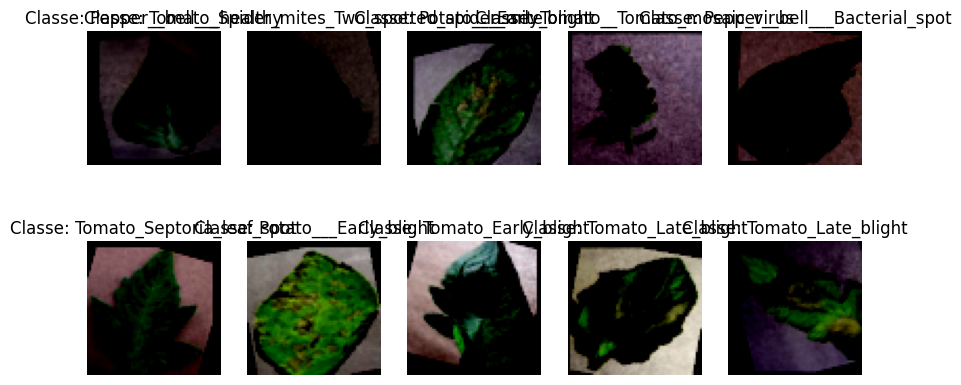

In [26]:
import matplotlib.pyplot as plt
import random

# Afficher quelques images aléatoires du dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for ax in axes.flat:
    idx = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[idx]
    ax.imshow(img.permute(1, 2, 0))  # Convertir le format pour affichage
    ax.set_title(f"Classe: {train_dataset.classes[label]}")
    ax.axis("off")

plt.show()

#Création des DataLoaders

In [27]:
from torch.utils.data import DataLoader

# Définition des paramètres
batch_size = 32  # On peut ajuster selon la mémoire dispo
shuffle = True  # Mélanger les données pour éviter le sur-apprentissage

# Création du DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Vérification
for images, labels in train_loader:
    print(f"Taille du batch: {images.shape}, Labels: {labels.shape}")
    break  # On affiche juste un batch pour tester


Taille du batch: torch.Size([32, 3, 64, 64]), Labels: torch.Size([32])


#Lecture des donnes

In [28]:
from multiprocessing import Pool, cpu_count
def read_class_images(class_directory_path, class_name):
    """
    Lit toutes les images d'une classe (maladie des plantes).
    """
    datax = []
    datay = []

    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")  # Extensions valides
    images = os.listdir(class_directory_path)

    for img in images:
        img_path = os.path.join(class_directory_path, img)

        # Vérifier si le fichier a une extension valide
        if not img.lower().endswith(valid_extensions):
            print(f"⚠️ Fichier ignoré : {img_path}")
            continue

        try:
            # Ouvrir l'image avec PIL et appliquer les transformations
            image = Image.open(img_path).convert("RGB")
            image = transform(image)  # Appliquer les transformations

            datax.append(image)
            datay.append(class_name)  # On garde le nom de la classe comme label

        except Exception as e:
            print(f"❌ Erreur lors de la lecture de {img_path}: {e}")

    return datax, datay




In [29]:
def read_images(base_directory):
    """
    Lit toutes les classes depuis PlantVillage en utilisant du multiprocessing.
    """
    datax = []
    datay = []

    classes = os.listdir(base_directory)
    pool = Pool(cpu_count())

    results = pool.starmap(read_class_images, [(os.path.join(base_directory, class_name), class_name) for class_name in classes])

    pool.close()
    pool.join()

    for result in results:
        datax.extend(result[0])
        datay.extend(result[1])

    return np.array(datax), np.array(datay)

#Chargement final des données

In [30]:
train_path = "PlantVillage/train"
test_path = "PlantVillage/test"

trainx, trainy = read_images(train_path)
testx, testy = read_images(test_path)

# 📌 Vérification
print(f"✅ trainx shape: {trainx.shape}, trainy shape: {trainy.shape}")
print(f"✅ testx shape: {testx.shape}, testy shape: {testy.shape}")

⚠️ Fichier ignoré : PlantVillage/train/train/Tomato_Septoria_leaf_spot
⚠️ Fichier ignoré : PlantVillage/train/train/Tomato_Spider_mites_Two_spotted_spider_mite
⚠️ Fichier ignoré : PlantVillage/train/train/Potato___Early_blight
⚠️ Fichier ignoré : PlantVillage/train/train/Tomato_healthy
⚠️ Fichier ignoré : PlantVillage/train/train/Tomato_Early_blight
⚠️ Fichier ignoré : PlantVillage/train/train/Tomato_Late_blight
⚠️ Fichier ignoré : PlantVillage/train/train/Pepper__bell___Bacterial_spot
⚠️ Fichier ignoré : PlantVillage/train/train/Tomato__Target_Spot
⚠️ Fichier ignoré : PlantVillage/train/train/Tomato__Tomato_mosaic_virus
⚠️ Fichier ignoré : PlantVillage/train/train/Pepper__bell___healthy
⚠️ Fichier ignoré : PlantVillage/test/test/Potato___healthy
⚠️ Fichier ignoré : PlantVillage/test/test/Tomato_Bacterial_spot
⚠️ Fichier ignoré : PlantVillage/test/test/Tomato_Leaf_Mold
⚠️ Fichier ignoré : PlantVillage/test/test/Tomato__Tomato_YellowLeaf__Curl_Virus
⚠️ Fichier ignoré : PlantVillage/test

#creation des samples

In [31]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Sélectionne un échantillon de taille (n_way, n_support + n_query) pour chaque classe.

    Args:
        n_way (int): Nombre de classes à sélectionner
        n_support (int): Nombre d'exemples par classe pour l'ensemble support
        n_query (int): Nombre d'exemples par classe pour l'ensemble query
        datax (np.array): Tableau numpy des images sous forme (N, C, H, W)
        datay (np.array): Tableau numpy des labels associés (N,)

    Returns:
        dict:
            - images (torch.Tensor): Tensor (n_way, n_support+n_query, C, H, W)
            - n_way, n_support, n_query (int)
    """
    datax = np.array(datax)  # S'assurer que c'est un np.array
    datay = np.array(datay)

    sample = []
    classes = np.unique(datay)  # Obtenir les classes uniques

    # Sélectionner n_way classes aléatoires
    chosen_classes = np.random.choice(classes, n_way, replace=False)

    for cls in chosen_classes:
        # Indices des images correspondant à la classe
        class_indices = np.where(datay == cls)[0]

        # Sélectionner les images correspondantes
        datax_cls = datax[class_indices]

        # Mélanger les images pour éviter un biais
        perm = np.random.permutation(len(datax_cls))

        # Prendre n_support + n_query images
        sample_cls = datax_cls[perm[:(n_support + n_query)]]

        sample.append(sample_cls)

    # Convertir en numpy array
    sample = np.array(sample)  # Shape: (n_way, n_support+n_query, C, H, W)

    # Conversion en tensor PyTorch
    sample = torch.from_numpy(sample).float()

    return {
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    }

In [32]:
def display_sample(sample):
    """
    Affiche un échantillon sous forme de grille.

    Args:
        sample (torch.Tensor): Échantillon d'images à afficher
    """
    # Convertir en 4D (batch, C, H, W) pour `make_grid`
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])

    # Créer une grille d'images
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    # Affichage
    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


#Model

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encodant les images du dataset
        """
        super(ProtoNet, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = encoder.to(self.device)

    def forward(self, x):
        """Encode directement les images avec le CNN"""
        return self.encoder(x.to(self.device))

    def set_forward_loss(self, sample):
        """
        Calcule la perte et l'accuracy du modèle.
        Args:
            sample (dict): contient 'images' (Tensor), n_way, n_support, n_query
        Returns:
            loss, {'loss': loss, 'acc': accuracy, 'y_hat': predictions}
        """
        sample_images = sample['images'].to(self.device)
        n_way, n_support, n_query = sample['n_way'], sample['n_support'], sample['n_query']

        # Séparer support et query
        x_support = sample_images[:, :n_support]  # (n_way, n_support, C, H, W)
        x_query = sample_images[:, n_support:]    # (n_way, n_query, C, H, W)

        # Indices cibles
        target_inds = torch.arange(n_way).view(n_way, 1).expand(n_way, n_query).to(self.device)

        # Encoder les images (support + query)
        x = torch.cat([x_support.reshape(n_way * n_support, *x_support.shape[2:]),
                       x_query.reshape(n_way * n_query, *x_query.shape[2:])], dim=0)
        z = self.encoder(x)

        # Définir les prototypes
        z_dim = z.size(-1)  # Taille de l'espace de sortie
        z_proto = z[:n_way * n_support].view(n_way, n_support, z_dim).mean(dim=1)  # (n_way, z_dim)
        z_query = z[n_way * n_support:]  # (n_way * n_query, z_dim)

        # Calcul des distances euclidiennes
        dists = euclidean_dist(z_query, z_proto)  # (n_way * n_query, n_way)

        # Probabilités
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        # Calcul de la loss
        loss_val = -log_p_y.gather(2, target_inds.unsqueeze(-1)).squeeze().mean()

        # Prédictions et accuracy
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat, target_inds).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
        }

#differente implentaions du CNN ppour tester la plus efficace

EfficientNet

In [ ]:
def load_protonet_conveff(model_name="efficientnet_b0", z_dim=64, fine_tune=True):
    """
    Charge un modèle ProtoNet basé sur EfficientNet avec fine-tuning optionnel.
    """
    efficientnet = getattr(models, model_name)(pretrained=True)

    if fine_tune:
        for param in efficientnet.parameters():
            param.requires_grad = False  # On freeze toutes les couches sauf la dernière

    # Remplacer la dernière couche FC par un embedding de dimension z_dim
    efficientnet.classifier = nn.Sequential(
        nn.Linear(efficientnet.classifier[1].in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(256, z_dim),
        nn.BatchNorm1d(z_dim)
    )

    return ProtoNet(efficientnet, z_dim)

ResNet18

In [ ]:
def load_protonet_convres(model_name='resnet18', z_dim=64, fine_tune=True):
    """
    Charge un modèle ProtoNet basé sur ResNet avec fine-tuning optionnel.
    """
    resnet = getattr(models, model_name)(pretrained=True)

    if fine_tune:
        for param in list(resnet.parameters())[:-5]:
            param.requires_grad = False

    resnet.fc = nn.Sequential(
        nn.Linear(resnet.fc.in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(256, z_dim),
        nn.BatchNorm1d(z_dim)
    )

    return ProtoNet(resnet, z_dim)

mobileNet

In [ ]:
def load_protonet_conv_mobilenet(z_dim=64, fine_tune=True):
    """
    Charge un modèle ProtoNet basé sur MobileNet avec fine-tuning optionnel.
    """
    mobilenet = models.mobilenet_v2(pretrained=True)

    if fine_tune:
        for param in mobilenet.features.parameters():
            param.requires_grad = False

    mobilenet.classifier = nn.Sequential(
        nn.Linear(mobilenet.last_channel, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(256, z_dim),
        nn.BatchNorm1d(z_dim)
    )

    return ProtoNet(mobilenet, z_dim)

CNN Simple

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    """
    Charge le modèle de Prototypical Network adapté à PlantVillage.
    Args:
        x_dim (tuple): dimensions des images (par défaut (3, 128, 128))
        hid_dim (int): dimension des couches cachées
        z_dim (int): dimension de l’espace de sortie
    Returns:
        ProtoNet: modèle Prototypical Network
    """
    x_dim = kwargs.get('x_dim', (3, 128, 128))  # 3 canaux (RGB), 128x128
    hid_dim = kwargs.get('hid_dim', 64)
    z_dim = kwargs.get('z_dim', 64)

    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    encoder = nn.Sequential(
        conv_block(x_dim[0], hid_dim),  # (3, 128, 128) → (hid_dim, 64, 64)
        conv_block(hid_dim, hid_dim),   # (hid_dim, 64, 64) → (hid_dim, 32, 32)
        conv_block(hid_dim, hid_dim),   # (hid_dim, 32, 32) → (hid_dim, 16, 16)
        conv_block(hid_dim, z_dim),     # (hid_dim, 16, 16) → (z_dim, 8, 8)
        Flatten()                       # Mise à plat pour le classifieur
    )

    return ProtoNet(encoder)


In [35]:
def euclidean_dist(x, y):
    """
    Calcule la distance euclidienne entre x et y.
    Args:
        x (torch.Tensor): shape (n, d) - n = n_way * n_query
        y (torch.Tensor): shape (m, d) - m = n_way
    Returns:
        torch.Tensor: shape(n, m) - distances de chaque query à chaque prototype
    """
    n, d = x.shape
    m, _ = y.shape
    assert d == y.shape[1]

    # Expand dimensions pour le broadcast
    x = x.unsqueeze(1).expand(n, m, d)  # (n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)  # (n, m, d)

    return torch.pow(x - y, 2).sum(dim=2)  # (n,

#Train

In [36]:
from tqdm import tqdm
import torch.optim as optim

In [37]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Entraîne le Prototypical Network.
    Args:
        model : modèle ProtoNet
        optimizer : optimiseur (Adam, SGD, etc.)
        train_x (np.array) : images du dataset d'entraînement
        train_y (np.array) : labels du dataset d'entraînement
        n_way (int) : nombre de classes par tâche
        n_support (int) : nombre d'exemples de support par classe
        n_query (int) : nombre d'exemples de query par classe
        max_epoch (int) : nombre d'époques
        epoch_size (int) : nombre d'épisodes par époque
    """
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    epoch = 0

    while epoch < max_epoch:
        running_loss = 0.0
        running_acc = 0.0

        for _ in tqdm(range(epoch_size), desc=f"Époch {epoch+1}/{max_epoch}"):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print(f"Époch {epoch+1} -- Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        epoch += 1
        scheduler.step()

train (CNN simple)


In [38]:
%%time

model = load_protonet_conv(
    x_dim=(3, 64, 64),  # Taille des images 64x64x3
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ajuster n_way selon le nombre de classes
n_way = 10
n_support = 20
n_query = 20

max_epoch = 20 # modifier avec 50
epoch_size = 500  # Réduire si RAM insuffisante

train(model, optimizer, trainx, trainy, n_way, n_support, n_query, max_epoch, epoch_size)


Époch 1/20: 100%|██████████| 500/500 [04:08<00:00,  2.01it/s]


Époch 1 -- Loss: 1.7514 Acc: 0.6374


Époch 2/20: 100%|██████████| 500/500 [04:07<00:00,  2.02it/s]


Époch 2 -- Loss: 0.5242 Acc: 0.8180


Époch 3/20: 100%|██████████| 500/500 [04:05<00:00,  2.03it/s]


Époch 3 -- Loss: 0.3462 Acc: 0.8813


Époch 4/20: 100%|██████████| 500/500 [04:03<00:00,  2.06it/s]


Époch 4 -- Loss: 0.2513 Acc: 0.9134


Époch 5/20: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Époch 5 -- Loss: 0.2059 Acc: 0.9292


Époch 6/20: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Époch 6 -- Loss: 0.1815 Acc: 0.9371


Époch 7/20: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Époch 7 -- Loss: 0.1648 Acc: 0.9417


Époch 8/20: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Époch 8 -- Loss: 0.1529 Acc: 0.9463


Époch 9/20: 100%|██████████| 500/500 [03:59<00:00,  2.08it/s]


Époch 9 -- Loss: 0.1499 Acc: 0.9479


Époch 10/20: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Époch 10 -- Loss: 0.1501 Acc: 0.9475


Époch 11/20: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Époch 11 -- Loss: 0.1524 Acc: 0.9464


Époch 12/20: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Époch 12 -- Loss: 0.1457 Acc: 0.9491


Époch 13/20: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Époch 13 -- Loss: 0.1435 Acc: 0.9495


Époch 14/20: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Époch 14 -- Loss: 0.1474 Acc: 0.9491


Époch 15/20: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Époch 15 -- Loss: 0.1448 Acc: 0.9491


Époch 16/20: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Époch 16 -- Loss: 0.1448 Acc: 0.9497


Époch 17/20: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Époch 17 -- Loss: 0.1498 Acc: 0.9483


Époch 18/20: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s]


Époch 18 -- Loss: 0.1446 Acc: 0.9496


Époch 19/20: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s]


Époch 19 -- Loss: 0.1475 Acc: 0.9482


Époch 20/20: 100%|██████████| 500/500 [04:03<00:00,  2.06it/s]

Époch 20 -- Loss: 0.1469 Acc: 0.9477
CPU times: user 41min 59s, sys: 38min 37s, total: 1h 20min 36s
Wall time: 1h 20min 45s


In [ ]:
scaler = torch.cuda.amp.GradScaler()

for batch in train_loader:
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():  # Active le mode mixte précision
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()


train (resnet)

In [ ]:
%%time

model = load_protonet_conveff(
      # Taille des images 64x64x3

    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ajuste n_way selon le nombre de classes
n_way = 10
n_support = 20
n_query = 20

max_epoch = 5
epoch_size = 500  # Réduire si RAM insuffisante

train(model, optimizer, trainx, trainy, n_way, n_support, n_query, max_epoch, epoch_size)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s]
Époch 1/5: 100%|██████████| 500/500 [17:47<00:00,  2.14s/it]


Époch 1 -- Loss: 0.9815 Acc: 0.7964


Époch 2/5: 100%|██████████| 500/500 [17:46<00:00,  2.13s/it]


Époch 2 -- Loss: 0.3987 Acc: 0.8852


Époch 3/5: 100%|██████████| 500/500 [17:50<00:00,  2.14s/it]


Époch 3 -- Loss: 0.2935 Acc: 0.9098


Époch 4/5: 100%|██████████| 500/500 [17:46<00:00,  2.13s/it]


Époch 4 -- Loss: 0.2469 Acc: 0.9226


Époch 5/5: 100%|██████████| 500/500 [17:47<00:00,  2.13s/it]

Époch 5 -- Loss: 0.2320 Acc: 0.9282
CPU times: user 44min 20s, sys: 44min 29s, total: 1h 28min 49s
Wall time: 1h 28min 58s


#Test

In [39]:
from tqdm import tnrange
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [40]:
n_way = 5
n_support = 10
n_query = 10

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

<ipython-input-39-e1506df7f7c6>:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.5408 Acc: 0.8336


#test results



1.  CNN simple : Loss: 0.5408 Acc: 0.8336 (20 epochs)
2.  resnet :Test results -- Loss: 7.4034 Acc: 0.5795
3. mobilenet Test results -- Loss: 3.4031 Acc: 0.6383
4. efficeint Test results -- Loss: 3.0548 Acc: 0.5811

